In [5]:
  
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report, f1_score,precision_recall_fscore_support)

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
LABELS = ["NO FRAUD", "FRAUD"]

In [3]:
df = pd.read_csv("creditcard.csv")

In [4]:

frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [5]:
#scale amount
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

#split  data to train and test
X_train, X_test = train_test_split(data, test_size=0.2, random_state= 42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values

In [6]:
#build model
input_dim = X_train.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

nb_epoch = 88
batch_size = 32
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",verbose=0,save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',histogram_freq=0,write_graph=True,write_images=True)
history = autoencoder.fit(X_train, X_train,epochs=nb_epoch,batch_size=batch_size,shuffle=True,
                    validation_data=(X_test, X_test),verbose=1,callbacks=[checkpointer, tensorboard]).history


autoencoder = load_model('model.h5')

Epoch 1/88
   1/7108 [..............................] - ETA: 0s - loss: 0.7388 - accuracy: 0.0312WARNING:tensorflow:From C:\Users\dasav\anaconda3\envs\MachineLearning\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
7108/7108 [==============================] - 17s 2ms/step - loss: 0.8118 - accuracy: 0.5900 - val_loss: 0.7803 - val_accuracy: 0.6641
Epoch 2/88
7108/7108 [==============================] - 18s 3ms/step - loss: 0.7398 - accuracy: 0.6699 - val_loss: 0.7617 - val_accuracy: 0.6795
Epoch 3/88
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7230 - accuracy: 0.6800 - val_loss: 0.7497 - val_accuracy: 0.6844
Epoch 4/88
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7153 - accuracy: 0.6899 - val_loss: 0.7455 - val_accuracy: 0.6914
Epoch 5/88
7108/7108 [=========

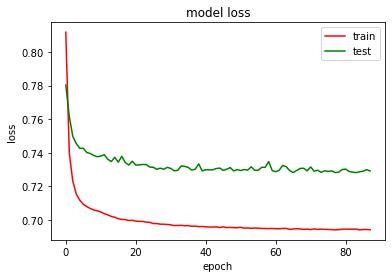

In [7]:
#plot epoch vs error/loss
plt.plot(history['loss'], color = "red")
plt.plot(history['val_loss'], color = "green")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [8]:
#predict error
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
print(error_df.describe())

       reconstruction_error    true_class
count          56962.000000  56962.000000
mean               0.727253      0.001720
std                3.407263      0.041443
min                0.037648      0.000000
25%                0.232000      0.000000
50%                0.380894      0.000000
75%                0.617498      0.000000
max              260.726330      1.000000


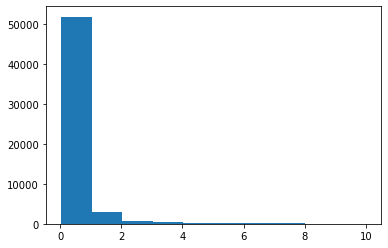

In [9]:
#no fraud
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
plt.show()

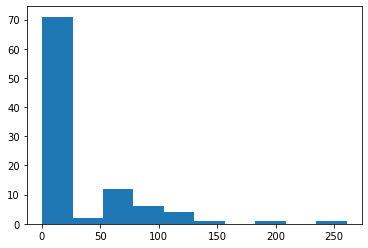

In [10]:
#fraud
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
plt.show()

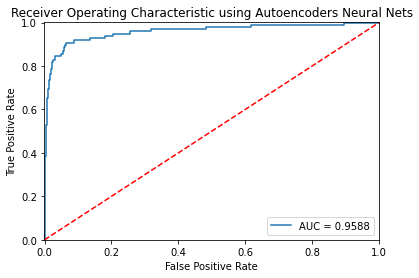

In [11]:
#auc roc curve
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic using Autoencoders Neural Nets')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

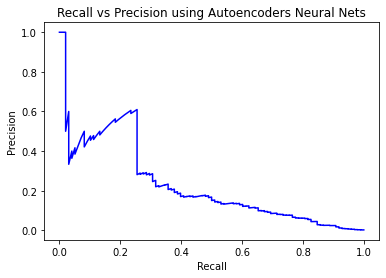

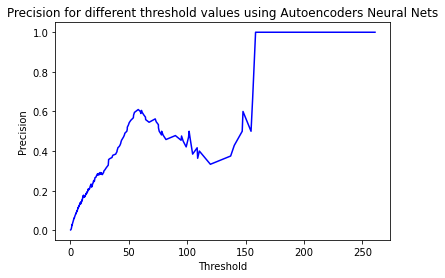

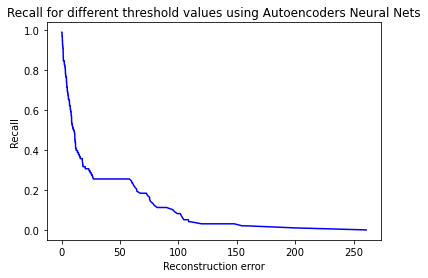

In [12]:
#percision recall curves
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision using Autoencoders Neural Nets')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values using Autoencoders Neural Nets')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values using Autoencoders Neural Nets')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

threshold = 3.5

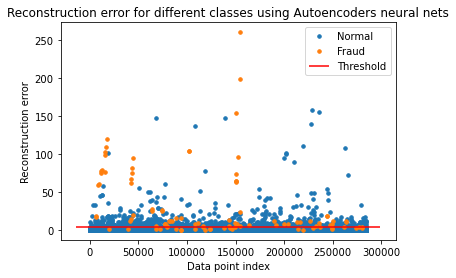

In [13]:
#predictions
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes using Autoencoders neural nets")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

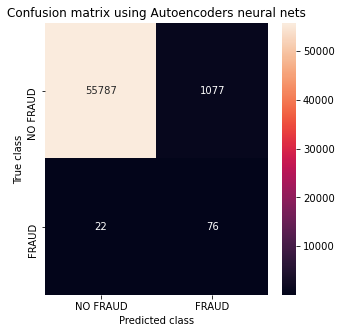

In [14]:
#confusion matrix
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix using Autoencoders neural nets")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()